# Trabalho 1
**Nome:** Fernando Ventilari, Kristhian André Oliveira Aguilar
**Data:** 16/10/2023

O objetivo deste trabalho é implementar e testar os seguintes algoritmos classificadores:
- Árvore de Decisão
- KNN (K-Vizinhos mais Próximos)
- Naive Bayes

Para isso, foram utilizadas as seguintes bibliotecas:
- Numpy, para manipulação de matrizes
- Pandas, para manipulação de tabelas e séries
- Scipy, para calcular as distâncias no KNN
- Scikit-learn, para carregar as bases de dados de teste
- Graphviz, para visualização da árvore de decisão

# Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd

RANDOM_SEED = 42

# Implementação

## KNN

In [2]:
from scipy.spatial.distance import cdist

class KNearestNeighours:
    def __init__(self, k) -> None:
        self.k = k
        self.X = None
        self.y = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
        
        self.unique_labels = np.unique(y)
        
        self.centroids = np.empty((len(self.unique_labels), self.X.shape[1]))
        
        for i, label in enumerate(self.unique_labels):
            label_mask = y == label
            self.centroids[i] = X[label_mask].mean(axis=0)
        
    def predict(self, X, metric='euclidean', k_means=False):
        
        if k_means:
            distances = cdist(X, self.centroids, metric=metric)
            sorting_indices = np.argsort(distances, axis=1)
            y_pred = np.take(self.unique_labels, sorting_indices[:, 0])
            return np.array(y_pred)
    
        
        # p-norm distance between each point in X and every point in self.X
        distances = cdist(X, self.X, metric=metric)

        # get k closest points indices
        sorting_indices = np.argsort(distances, axis=1)
        k_points = sorting_indices[:, :self.k]
        k_points_shape = k_points.shape
        
        # substitute point indices with its label
        k_labels = np.take(self.y, k_points.flatten())
        k_labels = np.array(k_labels).reshape(k_points_shape)
        
        # returns label with highest count
        def get_label(labels):
            label_values, counts = np.unique(labels, return_counts=True)
            prediction = label_values[np.argmax(counts)]
            return prediction

        y_pred = np.apply_along_axis(get_label, axis=1, arr=k_labels)
        return y_pred

## Naive Bayes

In [6]:
from enum import Enum

class NBDataType(Enum):
  CATEGORICAL = 0
  GAUSSIAN = 1

class NaiveBayes:
  def __init__(self, types : list[NBDataType]):
    self.types = types
    self.prior = None
    self.likelihood = None

  def fit(self, X, y):
    #USING ONLY NUMPY.NDARRAY
    if type(X) == pd.DataFrame:
      X = X.to_numpy()
    if type(y) == pd.Series:
      y = y.to_numpy()
    if type(X) != np.ndarray or type(y) != np.ndarray:
      raise TypeError(f"X and y must be numpy.ndarray or pandas.DataFrame and pandas.Series, respectively")

    if len(self.types) != X.shape[1]:
      raise TypeError(f"The number of types passed ({len(self.types)}) does not correspond to the number of columns in the dataset ({len(features)})")
    
    # calculate prior probabilities
    labels, counts = np.unique(y, return_counts=True)
    self.prior = dict(zip(labels, counts / len(y)))

    # calculate likelihood probabilities
    self.likelihood = {}

    for label in self.prior.keys():
      self.likelihood[label] = {}
      for i in range(X.shape[1]):
        if self.types[i] == NBDataType.GAUSSIAN:
          self.likelihood[label][i] = {
            "mean": X[y == label, i].mean(),
            "std": X[y == label, i].std()
          }
        elif self.types[i] == NBDataType.CATEGORICAL:
          self.likelihood[label][i] = np.unique(X[y == label, i], return_counts=True)[1] / len(X[y == label, i])
        else:
          raise TypeError(f"Invalid type {self.types[i]}")

  def gaussian(self, x, mean, std):
    return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))
  
  def predict_row(self, x_row):
    # calculate posterior probabilities
    posterior = {}
    for label in self.prior.keys():
      posterior[label] = self.prior[label]
      for i in range(len(x_row)):
        if self.types[i] == NBDataType.GAUSSIAN:
          posterior[label] *= self.gaussian(x_row[i], self.likelihood[label][i]["mean"], self.likelihood[label][i]["std"])
        elif self.types[i] == NBDataType.CATEGORICAL:
          posterior[label] *= self.likelihood[label][i][x_row[i]]
        else:
          raise TypeError(f"Invalid type {self.types[i]}")
    
    # return the label with the highest posterior probability
    return max(posterior, key=posterior.get)
  
  def predict(self, X):
    #USING ONLY NUMPY.NDARRAY
    if type(X) == pd.DataFrame:
      X = X.to_numpy()
    if type(X) != np.ndarray:
      raise TypeError(f"X must be numpy.ndarray or pandas.DataFrame")

    return np.array([self.predict_row(x_row) for x_row in X])

## Árvore de Decisão

### Base da Árvore

In [4]:
class Leaf:
    """A Leaf node classifies data.

    A leaf is the end of a partition in a decision tree. It holds all the labels that reached it.
    the label used to predict an example on the leaf is the one with the highest count.
    """

    def __init__(self, labels):
        
        self.predictions = dict(zip(*np.unique(labels, return_counts=True)))
        self.prediction = max(self.predictions)
    def __repr__(self) -> str:
        return str(self.prediction)

class DecisionNode:
    """A Decision Node asks a question using a feature and value of the dataset e.g "Is petal length > 5?".
     The question is used to partition the dataset in two: a true branch and a false branch.
    """

    def __init__(self,
                 feature,
                 value,
                 true_branch,
                 false_branch):
        self.feature = feature
        self.value = value
        self.true_branch = true_branch
        self.false_branch = false_branch
    
    def compare(self, X):
        """Compare the feature value in an example to the
        feature value in this question."""
        val = X[self.feature]
        if type(val) != str:
            return val >= self.value
        else:
            return val == self.value

### Funções Úteis

In [5]:
def node_to_string(node, feature_names) -> str:
    """This is just a helper method to print the question in a readable format."""
    condition = "=="
    if node.value != str:
        condition = ">="
    return f"Is {feature_names[node.feature]} {condition} {str(node.value)}?"

def gini(array):
    _, counts = np.unique(array, return_counts=True)
    impurity = 1
    
    value_probabilities = counts / len(array)
    impurity = 1 - np.square(value_probabilities).sum()
    return impurity

def information_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

def partition(X, y, feature, value):
    if type(value) != str:
        true_partition = (X[:, feature] > value)
    else:
        true_partition = (X[:, feature] == value)
    
    true_partition = true_partition.flatten()    

    X_true = X[true_partition]
    y_true = y[true_partition]
    X_false = X[~true_partition]
    y_false = y[~true_partition]
    
    return X_true, y_true, X_false, y_false

def find_best_split(X, y):
    """
    Tries to partition the data with every unique value of each column. 
    Returns the column and value split with with highest information gain.
    """
    best_gain = 0
    best_feature = None
    best_value = None
    current_uncertainty = gini(y)
    number_features = X.shape[1]
    
    for feature in range(number_features):
        for value in np.unique(X[:, feature]):
            

            X_true, y_true, X_false, y_false = partition(X, y, feature, value)

            # Skips split if it doesn't divide the dataset.            
            if len(X_true) == 0 or len(X_false) == 0:
                continue
            
            # Calculates the information gain from split
            gain = information_gain(y_true, y_false, current_uncertainty)
            
            if gain > best_gain:
                best_gain, best_feature, best_value = gain, feature, value
    return best_gain, best_feature, best_value

### Classe principal

In [6]:
import graphviz

class DecisionTree():
    def __init__(self) -> None:
        self.root = None
        self.feature_names = None
    
    def fit(self, X, y):
        if type(X) == pd.DataFrame:
            self.feature_names = X.columns
            X = X.to_numpy()
        else:
            self.feature_names = range(X.shape[1])
            
        def build_tree(X, y):

            # Partitions the dataset on every attribute,
            # calculates the information gain,
            # and returns the question that produces the highest gain.
            gain, feature, value = find_best_split(X, y)

            # Base case: no further info gain
            # Since we can ask no further questions,
            # we'll return a leaf.
            if gain == 0:
                return Leaf(y)

            # If we reach here, we have found a useful feature / value
            # to partition on.
            X_true, y_true, X_false, y_false = partition(X, y, feature, value)

            # Recursively build the true branch.
            true_branch = build_tree(X_true, y_true)

            # Recursively build the false branch.
            false_branch = build_tree(X_false, y_false)

            # Return a Question node.
            # This records the best feature / value to ask at this point,
            # as well as the branches to follow
            # dependingo on the answer.
            return DecisionNode(feature, value, true_branch, false_branch)
            
        self.root = build_tree(X,y)
    
    def predict(self, X):    
        y_pred = list()
        if type(X) == pd.DataFrame:
            X = X.to_numpy()
            
        def predict_example(example, node):

            # Base case: we've reached a leaf
            if isinstance(node, Leaf):
                return node.predictions

            # Decide whether to follow the true-branch or the false-branch.
            # Compare the feature / value stored in the node,
            # to the example we're considering.
            if node.compare(example):
                return predict_example(example, node.true_branch)
            else:
                return predict_example(example, node.false_branch)
        
        for i, example in enumerate(X):
            predictions = predict_example(example, self.root)
            prediction = max(predictions)
            
            y_pred.append(prediction)
        return y_pred
    
    def print_tree(self) -> str:
        dot = graphviz.Digraph()
        id_fn = lambda x: str(id(x))
        dot.node(id_fn(self.root), node_to_string(self.root, self.feature_names))
        
        def build_graph(node):
            """World's most elegant tree printing function."""

            # Base case: we've reached a leaf
            if isinstance(node, Leaf):
                # print (spacing + "Predict", node.predictions)
                return

            # Print the question at this node
            # print (spacing + node_to_string(node, feature_names))

            # Call this function recursively on the true branch
            # print (spacing + '--> True:')
            if isinstance(node.true_branch, DecisionNode):
                dot.node(id_fn(node.true_branch), node_to_string(node.true_branch, self.feature_names))
                dot.edge(id_fn(node), id_fn(node.true_branch), "True")
                build_graph(node.true_branch)
            else:
                dot.node(id_fn(node.true_branch), str(node.true_branch), shape='rectangle')
                dot.edge(id_fn(node), id_fn(node.true_branch), "True")

            # Call this function recursively on the false branch
            # print (spacing + '--> False:')
            if isinstance(node.false_branch, DecisionNode):
                dot.node(id_fn(node.false_branch), node_to_string(node.false_branch, self.feature_names))
                dot.edge(id_fn(node), id_fn(node.false_branch), "False")
                build_graph(node.false_branch)
            else:
                dot.node(id_fn(node.false_branch), str(node.false_branch), shape='rectangle')
                dot.edge(id_fn(node), id_fn(node.false_branch), "False")
            
        build_graph(self.root)
        return dot

# Teste dos Modelos

## Obtenção da base de dados

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_iris(return_X_y=True, as_frame=False)

## Divisão de treino e teste

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)

## Árvore de Decisão

A nossa árvore de decisão suporta tanto atributos numéricos quanto atributos catégoricos na mesma base.

In [9]:
from sklearn.tree import DecisionTreeClassifier as SKLDecisionTree
from sklearn.tree import plot_tree

In [10]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train)

sklearn_tree = SKLDecisionTree(random_state=RANDOM_SEED)
sklearn_tree.fit(X_train, y_train);

In [11]:
y_pred = my_tree.predict(X_test)
print(f"Nossa árvore de decisão: {accuracy_score(y_test, y_pred)*100:.2f}%")

y_pred = sklearn_tree.predict(X_test)
print(f"Árvore de decisão do sklearn: {accuracy_score(y_test, y_pred)*100:.2f}%")

Nossa árvore de decisão: 100.00%
Árvore de decisão do sklearn: 100.00%


### Gráficos das árvores

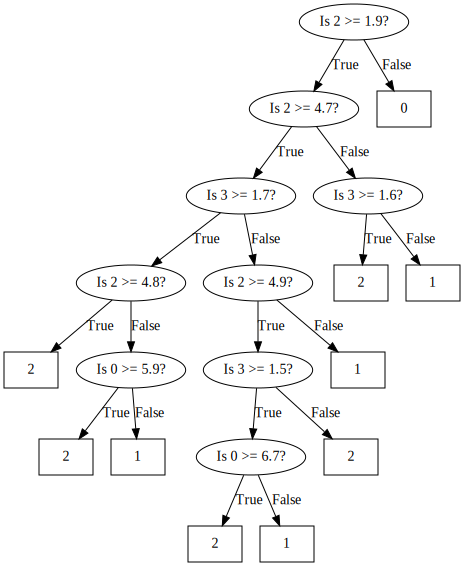

In [12]:
my_tree.print_tree()

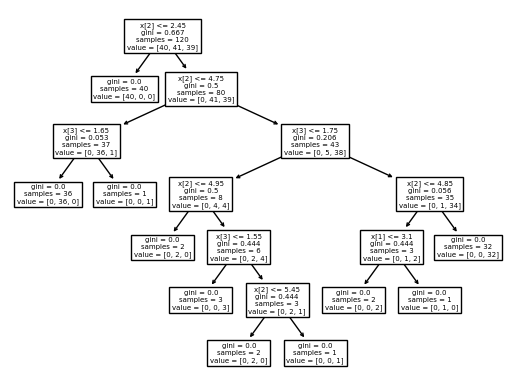

In [13]:
plot_tree(sklearn_tree);

## Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB

my_naive_bayes = NaiveBayes(types=[NBDataType.GAUSSIAN, NBDataType.GAUSSIAN, NBDataType.GAUSSIAN, NBDataType.GAUSSIAN])
my_naive_bayes.fit(X_train, y_train)

sklearn_naive_bayes = GaussianNB()
sklearn_naive_bayes.fit(X_train, y_train);

In [9]:
y_pred = my_naive_bayes.predict(X_test)
print(f"Nosso Naive Bayes: {accuracy_score(y_test, y_pred)*100:.2f}%")

y_pred = sklearn_naive_bayes.predict(X_test)
print(f"Naive Bayes sklearn: {accuracy_score(y_test, y_pred)*100:.2f}%")

Nosso Naive Bayes: 100.00%
Naive Bayes sklearn: 100.00%


## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

my_knn = KNearestNeighours(3)
sklearn_knn = KNeighborsClassifier(3)

my_knn.fit(X_train, y_train)
sklearn_knn.fit(X_train, y_train);

In [17]:
y_pred = my_knn.predict(X_test)
print(f"Nosso KNN: {accuracy_score(y_test, y_pred)*100:.2f}%")

y_pred = sklearn_knn.predict(X_test)
print(f"KNN do sklearn: {accuracy_score(y_test, y_pred)*100:.2f}%")

Nosso KNN: 100.00%
KNN do sklearn: 100.00%


### K-Means

In [18]:
from sklearn.cluster import KMeans

sklearn_kmeans = KMeans(n_clusters=len(np.unique(y)), n_init='auto', random_state=RANDOM_SEED);
sklearn_kmeans.fit(X_train);

In [19]:
y_pred = my_knn.predict(X_test, k_means=True)
print(f"Nosso K-Means: {accuracy_score(y_test, y_pred)*100:.2f}%")

y_pred = sklearn_kmeans.predict(X_test)
print(f"K-Means do sklearn: {accuracy_score(y_test, y_pred)*100:.2f}%")

Nosso K-Means: 96.67%
K-Means do sklearn: 36.67%
